## A simple-but-effective decision tree

Let's start with importing the libraries and the data. I used a csv version of the dataset, which you can find [here](https://github.com/andpalmier/MLWithPhishing).


In [2]:
import numpy as np
from sklearn import tree
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
import plotly.express as px

# Load the training data from a CSV file
training_data = np.genfromtxt('phishing_smaller.csv', delimiter=',', dtype=np.int32)

The csv has 10.000 samples with 11 columns, where the last one is the label of the sample, while the other values are the features.

In [3]:
# inputs are in all columns except the last one
inputs = training_data[:,:-1]

# outputs in the last column
outputs = training_data[:, -1]

We will use `StratifiedKFold` to keep the frequency of the classes constant during our K-fold cross-validation. The `random_state` parameter is used for k-fold and the classifier to reproduce the same setup for all the iterations of the model.

In [4]:
from sklearn.model_selection import StratifiedKFold

# use 10-fold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

In order to evaluate how good is our classifier, I will use AUC (Area Under Curve), you can find more information about it [in this video](https://www.youtube.com/watch?v=OAl6eAyP-yo).

Here is how to create, train and evaulate our decision tree:

In [5]:
# library for evaluating the classifier
import sklearn.metrics as metrics

# array to store the accuracy during k-fold cross-validation
accuracy = np.array([])

# loop with splits
for train_index, test_index in skf.split(inputs, outputs):
    
    # 9 folds used for training
    X_train, X_test = inputs[train_index], inputs[test_index]
    # 1 fold for testing
    y_train, y_test = outputs[train_index], outputs[test_index]

    # Create a decision tree classifier 
    classifier = tree.DecisionTreeClassifier(random_state=0)
    
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Test the classifier
    predictions = classifier.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(y_test, predictions)
    # calculate classifier accuracy
    ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
    accuracy = np.append(accuracy,ROC_AUC)
    
print("ROC AUC: "+str(np.mean(accuracy)))

ROC AUC: 0.9182929859719439


Not bad, but can we improve the accuracy of this decision tree with some tuning?

## Criterion/splitter tuning

If we take a look at [the scikit-learn documentation for the decision tree classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), we can see that there are many parameters available. The first two are the `criterion` and `splitter`, having both two possible values. The supported criteria are `gini` (for [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)) and `entropy` (for [information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees)); while the supported strategies available for splitting a node are `best` and `random`.

In total, we have 4 possible combinations: let's try them to check which one performs better.

In [6]:
# AUC scores for test
results = []

# First= gini, best: default classifier
first_classifier = tree.DecisionTreeClassifier(random_state=0 \
    ,criterion="gini",splitter="best")
first_accuracy = np.array([])

# Second= gini, random
second_classifier = tree.DecisionTreeClassifier(random_state=0 \
    ,criterion="gini",splitter="random")
second_accuracy = np.array([])

# Third= entropy, best
third_classifier = tree.DecisionTreeClassifier(random_state=0 \
    ,criterion="entropy",splitter="best")
third_accuracy = np.array([])

# Fourth= entropy, random
fourth_classifier = tree.DecisionTreeClassifier(random_state=0 \
    ,criterion="entropy",splitter="random")
fourth_accuracy = np.array([])

# use same folds
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
for train_index, test_index in skf.split(inputs, outputs):
    
    X_train, X_test = inputs[train_index], inputs[test_index]
    y_train, y_test = outputs[train_index], outputs[test_index]
    
    # Train and test the first classifier
    first_classifier.fit(X_train, y_train)
    predictions = first_classifier.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(y_test, predictions)
    # calculate classifier accuracy
    ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
    first_accuracy = np.append(first_accuracy,ROC_AUC)
    
    # Train and test the second classifier
    second_classifier.fit(X_train, y_train)
    predictions = second_classifier.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(y_test, predictions)
    # calculate classifier accuracy
    ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
    second_accuracy= np.append(second_accuracy,ROC_AUC)
    
    # Train and test the third classifier
    third_classifier.fit(X_train, y_train)
    predictions = third_classifier.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(y_test, predictions)
    # calculate classifier accuracy
    ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
    third_accuracy= np.append(third_accuracy,ROC_AUC)
    
    # Train and test the fourth classifier
    fourth_classifier.fit(X_train, y_train)
    predictions = fourth_classifier.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(y_test, predictions)
    # calculate classifier accuracy
    ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
    fourth_accuracy= np.append(fourth_accuracy,ROC_AUC)
    
    
print("Test AUC for 'gini, best':       ",np.mean(first_accuracy))
print("Test AUC for 'gini, random':     ",np.mean(second_accuracy))
print("Test AUC for 'entropy, best':    ",np.mean(third_accuracy))
print("Test AUC for 'entropy, random':  ",np.mean(fourth_accuracy))

Test AUC for 'gini, best':        0.9182929859719439
Test AUC for 'gini, random':      0.9181927855711424
Test AUC for 'entropy, best':     0.9180925851703409
Test AUC for 'entropy, random':   0.9182929859719439


In this case, the criterion and splitter seems to not affect much the performance of the classifier (the maximum difference is below 0,1%).

## Tuning: max depth

Another parameter of the decision tree that we can tune is `max_depth`, which indicates the maximum depth of the tree. By default, this is is set to `None`, which means that nodes are expanded until all leaves are pure or contain less than `min_sample_split` samples.

Considering that we have 10 parameters, we will test the performances of trees having `max_depths` between 1 and 10.


In [7]:
# AUC scores for training and test
training_results = []
test_results = []

# use same folds
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# from 1 to 10
max_depths = range(1,11)

for i in max_depths:
    
    # loop with splits
    for train_index, test_index in skf.split(inputs, outputs):
        training_accuracy = np.array([])
        test_accuracy = np.array([])
        
        X_train, X_test = inputs[train_index], inputs[test_index]
        y_train, y_test = outputs[train_index], outputs[test_index]
        
        # Create a decision tree classifier
        classifier = tree.DecisionTreeClassifier(random_state=0,max_depth=i)
    
        # Train the classifier
        classifier.fit(X_train, y_train)
        
        # Accuracy of the classifier during training
        training_predictions = classifier.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = \
            metrics.roc_curve(y_train, training_predictions)
        ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
        training_accuracy = np.append(training_accuracy,ROC_AUC)
        
        # Test the classifier
        testing_predictions = classifier.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = \
            metrics.roc_curve(y_test, testing_predictions)
        
        # Accuracy of the classifier during test
        ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
        test_accuracy = np.append(test_accuracy,ROC_AUC)
        
    # append results with line chart
    training_results.append(np.mean(training_accuracy))
    test_results.append(np.mean(test_accuracy))

In order to visualize the results, let's use `matplotlib` to draw a line chart.

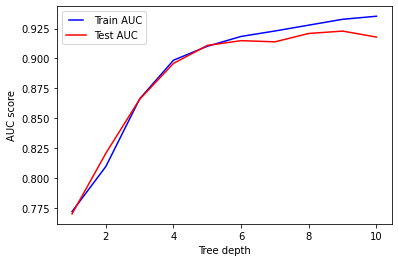

In [9]:
# training results in blue
line1, = plt.plot(max_depths, training_results, 'b', label='Train AUC')
# test results in red
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

As expected, increasing `max_depth` allows the model to be more specific when predicting the class of the given sample, thus improving the accuracy during training and test.

## Tuning: min sample splits

The next parameter is `min_samples_split`:
- If `int`, it represents the minimum number of samples required to split an internal node.
- If `float`, it is considered a fraction and `ceil(min_samples_split * len(samples))` are the minimum number of samples for each split.

While the default value is 2, we will test the performance of our classifier having `min_samples_split` between 0.05 and 1.0.


In [10]:
# AUC scores for training and test
training_results = []
test_results = []

# use same folds
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# from 5% to 100%
min_samples_splits = np.linspace(0.05, 1.0,20,endpoint=True)

for i in min_samples_splits:

    # loop with splits
    for train_index, test_index in skf.split(inputs, outputs):
        training_accuracy = np.array([])
        test_accuracy = np.array([])
        X_train, X_test = inputs[train_index], inputs[test_index]
        y_train, y_test = outputs[train_index], outputs[test_index]
        
        # Create a decision tree classifier
        classifier = tree.DecisionTreeClassifier(random_state=0,min_samples_split=i)
        
        # Train the classifier
        classifier.fit(X_train, y_train)
        
        # Accuracy of the classifier during training
        training_predictions = classifier.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = \
            metrics.roc_curve(y_train, training_predictions)
        ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
        training_accuracy = np.append(training_accuracy,ROC_AUC)
        
        # Test the classifier
        testing_predictions = classifier.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = \
            metrics.roc_curve(y_test, testing_predictions)
        
        # Accuracy of the classifier during test
        ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
        test_accuracy = np.append(test_accuracy,ROC_AUC)
    
    # append results for line chart
    training_results.append(np.mean(training_accuracy))
    test_results.append(np.mean(test_accuracy))

Again, let's visualize the results with a line chart:


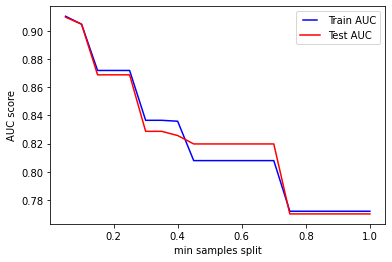

In [11]:
# plot line chart
line1, = plt.plot(min_samples_splits, training_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show() 

We can clearly see from the chart how increasing `min_samples_split` results in an underfitting case, where the model is not able to learn from the samples during training.

## Tuning: min samples leaf

Similarly to the previous parameter, `min_samples_leaf` can be:
- `int`, and it is used to specify the minimum number of samples required to be at a leaf node
- if `float`, it represents a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node

By default, the value is set to 1, but we will consider the cases where it goes from 0.05 to 0.5.

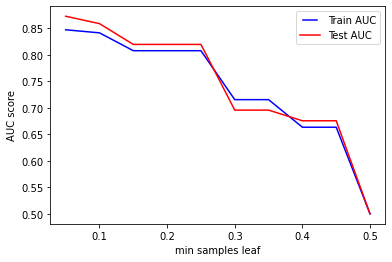

In [12]:
# AUC scores for training and test
training_results = []
test_results = []

# from 5% to 50%
min_samples_leaves = np.linspace(0.05, 0.5, 10,endpoint=True)

for i in min_samples_leaves:
    
    StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    
    # loop with splits
    for train_index, test_index in skf.split(inputs, outputs):
        training_accuracy = np.array([])
        test_accuracy = np.array([])
        X_train, X_test = inputs[train_index], inputs[test_index]
        y_train, y_test = outputs[train_index], outputs[test_index]
        
        # Create a decision tree classifier 
        classifier = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=i)
        
        # Train the classifier
        classifier.fit(X_train, y_train)
        
        # Accuracy of the classifier during training
        training_predictions = classifier.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = \
            metrics.roc_curve(y_train, training_predictions)
        ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
        training_accuracy = np.append(training_accuracy,ROC_AUC)
        
        # Test the classifier
        testing_predictions = classifier.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = \
            metrics.roc_curve(y_test, testing_predictions)
        
        # Accuracy of the classifier during test
        ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
        test_accuracy = np.append(test_accuracy,ROC_AUC)
    
    # append results for line chart
    training_results.append(np.mean(training_accuracy))
    test_results.append(np.mean(test_accuracy))

# print line chart
line1, = plt.plot(min_samples_leaves, training_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leaves, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

We can see that, similarly to the tuning of `min_samples_split`, increasing `min_samples_leaf` cause our model to underfit, drastically affecting the accuracy of the classifier during training and test.

## Tuning: max features

The last parameter we are going to consider is `max_features`, which specifies the number of features to consider when looking for the best split.

- If `int`, then consider `max_features` features at each split.
- If `float`, is a fraction and `int(max_features * n_features)` features are considered at each split.
- By default it is `None`, and `max_features=n_features`

Considering the number of features of our dataset, we will test measure the precision of classifiers having `max_features` between 1 and 10.

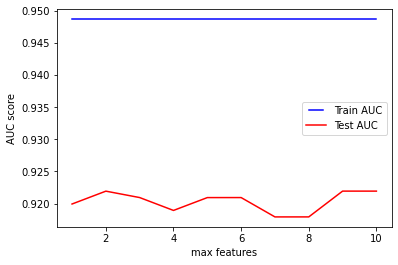

In [13]:
# AUC scores for training and test
training_results = []
test_results = []

# from 1 to 10 features
max_features = list(range(1,len(inputs[0])+1))

for i in max_features:
    
    StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    
    # loop with splits
    for train_index, test_index in skf.split(inputs, outputs):
        training_accuracy = np.array([])
        test_accuracy = np.array([])
        X_train, X_test = inputs[train_index], inputs[test_index]
        y_train, y_test = outputs[train_index], outputs[test_index]
        
        # Create a decision tree classifier
        classifier = tree.DecisionTreeClassifier(random_state=0,max_features=i)
        
        # Train the classifier
        classifier.fit(X_train, y_train)
        
        # Accuracy of the classifier during training
        training_predictions = classifier.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = \
            metrics.roc_curve(y_train, training_predictions)
        ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
        training_accuracy = np.append(training_accuracy,ROC_AUC)
        
        # Test the classifier
        testing_predictions = classifier.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = \
            metrics.roc_curve(y_test, testing_predictions)
        
        # Accuracy of the classifier during test
        ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
        test_accuracy = np.append(test_accuracy,ROC_AUC)
   
    # append results for line chart
    training_results.append(np.mean(training_accuracy))
    test_results.append(np.mean(test_accuracy))

# print line chart
line1, = plt.plot(max_features, training_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()


We can see how the accuracy of the model does not seems to improve much when increasing the number of features considered during a split. While this may seem counter-intuitive, the scikit-learn documentation specifies that '*the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features*.'


## Conclusion

These posts will investigate how tuning some of the available parameters can affect the performance of simple models. In this case, we saw how `criterion`, `splitter`, `max_depth`, `min_samples_split`, `min_samples_leaf` and `max_features` alter the predictions of a decision tree.

As pointed out from a friend, this is not the proper way of tuning the parameters of a model: you should use something like [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead.
